# Optimization

To remind, necessary ingredients to train NN:
    * model
    * objective
    * optimizer
    
Today we will try to understand basics of optimization of neural networks, giving context for the last two lectures. Goal is to:
* Understand the difference between optimization and generalization
* Understand basics of generalization (more on that in "Understanding generalization" lab)
* Understand role of hyperparameters in SGD

References:
* Deep Learning book chapter on optimization: http://www.deeplearningbook.org/contents/optimization.html

# Setup

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import json

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch import optim

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# Convert to Torch Tensor. Just to avoid boilerplate code later
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Training loop adapted from 4_computing_gradient.ipynb

def build_mlp(input_dim, output_dim, hidden_dim=512):
    model = torch.nn.Sequential()
    model.add_module("linear_1", torch.nn.Linear(input_dim, hidden_dim, bias=False))
    model.add_module("nonlinearity_1", torch.nn.ReLU())
    model.add_module("linear_2", torch.nn.Linear(hidden_dim, output_dim, bias=False))
    return model

def build_logreg(input_dim, output_dim, hidden_dim=512):
    model = torch.nn.Sequential()
    model.add_module("linear_2", torch.nn.Linear(input_dim, output_dim, bias=False))
    return model

def step(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward(retain_graph=True)

    # Update parameters
    optimizer.step()

    return output.data[0]

def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)

def train(model, loss, optim):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42)
    n_examples, n_features = x_train.size()
    n_classes = 10
    batch_size = 100
    history = {"acc": [], "test_acc": []}
    for i in tqdm.tqdm(range(100), total=100):
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
        
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
 
        # Note: usually it is computed from per batch averages
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

In [33]:
def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

# Generalization 101: learning curves and bias/variance decomposition

To talk about optimization, it is important to understand the difference between optimization and generalization.

Optimization is sort-of easy, in the sense it is much more important to generalize than to optimize (but the two co-incide in SGD, optimization gives usually good generalization):

<img width=300 src="fig/7/overfittingspiral.png">

## Learning curves

In [27]:
model = build_mlp(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, optim=optimizer)

100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


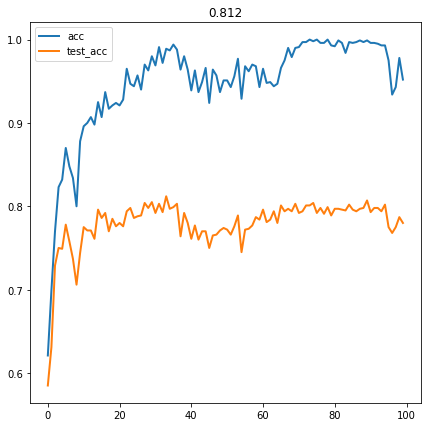

In [34]:
plot(H)

## Bias-variance

One way to understand generalization in machine learnning is through the bias-variance tradeoff. Other ways will be discussed next time.

<img width=200 src="fig/7/bias-and-variance.jpg">

<img width=600 src="fig/7/bias-and-variance2.png">

<p>
<font size=4>
$$E[(y - \hat{f(x)})^2] = Bias[\hat{f(x)}]^2 + Var[\hat{f(x)}] + \sigma^2$$, where

$$Bias[f(x)] = E[\hat{f(x)} - f(x)], Var[\hat{f(x)}] = E[(\hat{f(x)} - E[\hat{f(x)}])^2]$$
</font>
</p>

Reference:

https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff

## Exercise 1

Train 10 different logistic regressions and MLPs (hidden_dim=100) using same optimization hyperparameters. Answer the following questions:
    
a) Which achieves the lowest test error?

b) What is the *mean* test accuracy of MLP?

c) Which has the lower variance, and how do you know?

Additionally: plot train accuracy curve for all runs

Please, save answers to json (as in the next cell). Do not change name of the json file.

Hint:
    * Use torch.manual_seed(seed) to set seed for each repetition

In [54]:
answers = {"a": "", "b": "", "c": ""}
json.dump(answers, open("7_ex1.json", "w"))

In [48]:
results = {"logreg": [], "mlp": []}
for seed in range(5):
    torch.manual_seed(seed)
    model = build_logreg(784, 10, hidden_dim=hdim)
    loss = torch.nn.CrossEntropyLoss(size_average=True)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    H = train(loss=loss, model=model, optim=optimizer)
    results["logreg"].append(H)
    
for seed in range(5):
    torch.manual_seed(seed)
    model = build_mlp(784, 10, hidden_dim=100)
    loss = torch.nn.CrossEntropyLoss(size_average=True)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    H = train(loss=loss, model=model, optim=optimizer)
    results["mlp"].append(H)
    
np.std([max(H['test_acc']) for H in results["logreg"]])
np.mean([max(H['test_acc']) for H in results["logreg"]])

for H in results["mlp"]:
    plt.plot(H['acc'])
    
for H in results["logreg"]:
    plt.plot(H['acc'])

100%|██████████| 100/100 [00:02<00:00, 38.54it/s]


# Understanding curvature, SGD on Linear Regression

## Exercise: Maximum LR and curvature

# SGD(M) hyperparameters

# Exercise: impact of hyperparameters on learning

## Tune base LR and BS